<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/SNS/Act_3_3/SNS_Act_3_3_IRIS_con_NaiveBayes_y_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IRIS con NaiveBayes y Cross Validation

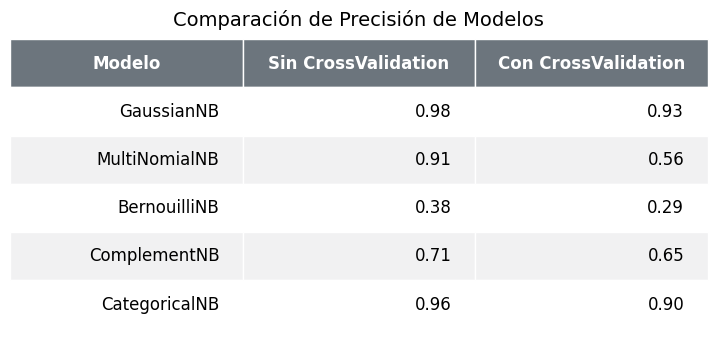

In [8]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB

# Cargar el dataset Iris
# Este dataset incluye datos de 3 clases de flores: Setosa, Versicolor y Virginica
# Las características son medidas continuas de longitud y ancho del sépalo y pétalo
iris = load_iris()
X, y = iris.data, iris.target

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
# El parámetro random_state asegura reproducibilidad en las divisiones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos para ciertos modelos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista de nombres de los modelos y clasificadores
names = ["GaussianNB", "MultiNomialNB", "BernouilliNB", "ComplementNB", "CategoricalNB"]
classifiers = [
    GaussianNB(),
    MultinomialNB(),
    BernoulliNB(),
    ComplementNB(),
    CategoricalNB(min_categories=3)
]

# Configuración de validación cruzada
# Utilizamos KFold con 5 particiones, mezclando los datos en cada iteración
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []  # Para almacenar las puntuaciones de validación cruzada
test_accuracies = []  # Para almacenar las precisiones en el conjunto de prueba

# Evaluar cada modelo
for name, clf in zip(names, classifiers):
    # Evaluación en el conjunto de prueba
    if name in ["MultiNomialNB", "BernouilliNB", "ComplementNB"]:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    elif name == "CategoricalNB":
        X_train_cat = X_train.astype(int)
        X_test_cat = X_test.astype(int)
        clf.fit(X_train_cat, y_train)
        y_pred = clf.predict(X_test_cat)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Calcular precisión en el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)

    # Validación cruzada
    fold_accuracies = []
    for train_index, test_index in cv.split(X_train):
        if name in ["MultiNomialNB", "BernouilliNB", "ComplementNB"]:
            clf.fit(X_train_scaled[train_index], y_train[train_index])
            y_fold_pred = clf.predict(X_train_scaled[test_index])
        elif name == "CategoricalNB":
            clf.fit(X_train_cat[train_index], y_train[train_index])
            y_fold_pred = clf.predict(X_train_cat[test_index])
        else:
            clf.fit(X_train[train_index], y_train[train_index])
            y_fold_pred = clf.predict(X_train[test_index])

        fold_accuracy = accuracy_score(y_train[test_index], y_fold_pred)
        fold_accuracies.append(fold_accuracy)

    # Calcular precisión media en validación cruzada
    cv_mean_accuracy = np.mean(fold_accuracies)
    cv_scores.append(cv_mean_accuracy)

# Crear un DataFrame para mostrar los resultados en formato de tabla
results_df = pd.DataFrame({
    "Modelo": names,
    "Sin CrossValidation": [f"{x:.2f}" for x in test_accuracies],
    "Con CrossValidation": [f"{x:.2f}" for x in cv_scores]
})

# Mostrar la tabla estilizada
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12, header_color='#40466e',
                     row_colors=['#f1f1f2', 'w'], edge_color='w', bbox=[0, 0, 1, 1],
                     header_font_color='w', ax=None, **kwargs):
    """Renderiza un DataFrame de pandas como una tabla con estilo usando Matplotlib."""
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    for k, cell in mpl_table.get_celld().items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_facecolor(header_color)
            cell.set_text_props(weight='bold', color=header_font_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax

# Representar la tabla
render_mpl_table(results_df, header_color='#6c757d', header_font_color='w', font_size=12)
plt.title("Comparación de Precisión de Modelos", fontsize=14, pad=10)
plt.show()
